In [22]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import scienceplots
import latex

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import optuna
from optuna import Trial


# Set plotting parameters
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')

# Read data
df = load(config['PATH']['DATA_DIR'] + '/full_df_agg_cap95.joblib')

### Set up as classification problem
For a classification problem we need a discrete target (multiple classes), as the target is average mood we need to transform the target.
We therefore round to the closest integer.


In [23]:
# Construct target as bad (0-6), okay (6-8), good (8-10)
df['target'] = df['target'].apply(lambda x: 0 if x < 7 else 1)


In [24]:
# id as one-hot encoded variable
df = pd.get_dummies(df, columns=['id'], prefix='id')
df

# Impute outliers (larger than 1.5 IQR) with mean of column in all _sum columns
for col in df.columns:
    if col.endswith('_sum'):
        df[col] = df[col].mask(df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)), df[col].mean())


## Train test split
As we are dealing with time series data we can't take a random 70/30 split of the data. 


[datetime.date(2014, 4, 25)]

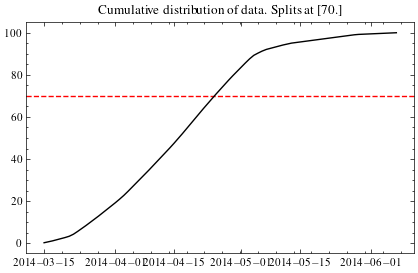

In [25]:
find_split_ts(df, 0.7, plot_data = True)

# Classification algorithm 
We optimize over parameters but also over classification algorithm
Included algorithms are: 
* RandomForest
* GradientBoosting
* NaiveBayes
* SVC
* KNN


In [26]:
X, y = df.drop(columns=['target'], axis = 1), df['target']

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_ts(X, y, split_ratios=[0.7, 0.1])

# Create the column transformer for standardization
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), list(X_train.columns))
    ])

# Define the objective function for the optimization
def objective(trial: Trial):
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'GradientBoosting', "Naive Bayes", "SVC", "KNN"])

    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif classifier_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        classifier_obj = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    elif classifier_name == 'Naive Bayes':
        classifier_obj = GaussianNB()
    elif classifier_name == 'SVC':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        classifier_obj = SVC(C=C, kernel=kernel, decision_function_shape='ovr')
    else:  # KNN
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
        
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier_obj)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Optimize the pipeline using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.number}, Accuracy: {best_trial.value}")
print(f"Best params: {best_trial.params}")



[I 2023-04-16 14:01:38,756] A new study created in memory with name: no-name-917e4e3a-726b-4658-8a03-304e07f4ef37
[I 2023-04-16 14:01:38,792] Trial 0 finished with value: 0.672 and parameters: {'classifier': 'KNN', 'n_neighbors': 6}. Best is trial 0 with value: 0.672.
[I 2023-04-16 14:01:38,813] Trial 1 finished with value: 0.696 and parameters: {'classifier': 'Naive Bayes'}. Best is trial 1 with value: 0.696.
[I 2023-04-16 14:01:38,850] Trial 2 finished with value: 0.68 and parameters: {'classifier': 'KNN', 'n_neighbors': 15}. Best is trial 1 with value: 0.696.
[I 2023-04-16 14:01:59,864] Trial 3 finished with value: 0.76 and parameters: {'classifier': 'SVC', 'C': 174.84477809263748, 'kernel': 'linear'}. Best is trial 3 with value: 0.76.
[I 2023-04-16 14:02:01,187] Trial 4 finished with value: 0.688 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 73, 'learning_rate': 0.7762169809307314, 'max_depth': 6}. Best is trial 3 with value: 0.76.
[I 2023-04-16 14:02:01,245] T

Best trial: 11, Accuracy: 0.792
Best params: {'classifier': 'RandomForest', 'n_estimators': 200, 'max_depth': 10}


In [27]:
best_pipe = get_best_pipeline(best_trial, X_train)
best_pipe.fit(X_train, y_train)
pred = best_pipe.predict(X_test)
accuracy_score(y_test, pred)

0.7370689655172413

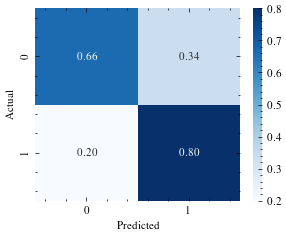

In [28]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



<Axes: >

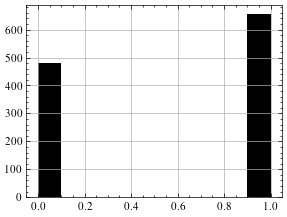

In [29]:
df['target'].hist()